# MSDS Thesis
## Data Analysis in Python for olfactoneuroimaging data

Apoorv Saraogee MSDS 599 - Dr. Srinivasan

## Setup of model and variables

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import visualkeras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Bidirectional, Flatten, GlobalAveragePooling3D, Lambda, Dense, TimeDistributed, LSTM, Permute, Reshape, Dropout, BatchNormalization, AveragePooling3D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
from keras.regularizers import l2

In [24]:
# Load the filtered DataFrame from the pickle file
input_pickle_file = 'filtered_events_simple_smaller.pkl'
filtered_combined_df = pd.read_pickle(input_pickle_file)

# Filter out rows where 'subject_id' is 'sub-22' and save in a separate DataFrame
sub_22_df = filtered_combined_df[filtered_combined_df['subject'] == 'sub-22']

# Remove 'sub-22' rows from the original DataFrame (NAB)
filtered_combined_df = filtered_combined_df[filtered_combined_df['subject'] != 'sub-22']

# Print the DataFrame to verify its contents
print(f"Loaded DataFrame from {input_pickle_file}:")
print(filtered_combined_df.head())


Loaded DataFrame from filtered_events_simple_smaller.pkl:
  subject run_modality  onset  dicom_start  dicom_end   smell response_type   
0  sub-13       run-02   33.4           22         38  banana      positive  \
1  sub-13       run-02  211.3          141        157  banana      positive   
2  sub-13       run-02  298.3          199        215  banana      positive   
3  sub-13       run-02  415.2          277        293  banana      positive   
4  sub-13       run-02  476.8          318        334  banana      positive   

                       idno                                               data  
0   sub-13_run-02_22_banana  [[[[ 0. -0. -0. -0. -0.  0.  0.  0. -0. -0. -0...  
1  sub-13_run-02_141_banana  [[[[-0.  0. -0. -0. -0. -0.  0.  0.  0.  0.  0...  
2  sub-13_run-02_199_banana  [[[[-0.  0. -0. -0. -0.  0. -0.  0.  0. -0. -0...  
3  sub-13_run-02_277_banana  [[[[-0. -0. -0.  0. -0.  0. -0. -0. -0. -0.  0...  
4  sub-13_run-02_318_banana  [[[[ 0.  0. -0.  0. -0. -0.  0. -

In [25]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the 'response_type' column
filtered_combined_df['label'] = label_encoder.fit_transform(filtered_combined_df['response_type'])

# Verify the transformation
print(filtered_combined_df[['response_type', 'label']].head())

# Extract data and labels
X = np.stack(filtered_combined_df['data'].values)  # Stack the arrays to create a 5D array
y = filtered_combined_df['label'].values  # Numeric labels

print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print("Type of data array:", type(X))
print("Data array dtype:", X.dtype)

  response_type  label
0      positive      1
1      positive      1
2      positive      1
3      positive      1
4      positive      1
Data shape: (405, 110, 104, 27, 16)
Labels shape: (405,)
Type of data array: <class 'numpy.ndarray'>
Data array dtype: float16


In [26]:
# Custom function for scaling each 4D observation independently
def min_max_scale_observation(observation):
    # Determine the max and min values across the whole observation
    max_val = np.max(observation)
    min_val = np.min(observation)
    
    # Scale only if the max and min are not the same (to avoid division by zero)
    if max_val != min_val:
        observation = 2 * (observation - min_val) / (max_val - min_val) - 1
    return observation

# Apply scaling to each observation (i.e., each 4D array) independently
X_scaled = np.array([min_max_scale_observation(obs) for obs in X])

# Verify the transformation
print(f"Scaled Data shape: {X_scaled.shape}")
print(f"Sample data range after scaling: min {X_scaled.min()}, max {X_scaled.max()}")

Scaled Data shape: (405, 110, 104, 27, 16)
Sample data range after scaling: min -1.0, max 1.0


In [27]:
model = Sequential([
    # Permute dimensions to have time as the first dimension for TimeDistributed
    Permute((4, 1, 2, 3), input_shape=(110, 104, 27, 16)),  # Shape becomes (16, 110, 104, 27)
    
    # Add a channel dimension (e.g., 1 channel)
    Lambda(lambda x: tf.expand_dims(x, -1)),  # Adds a channel dimension, shape becomes (16, 110, 104, 27, 1)
    
    # Apply Conv3D to each time slice independently using TimeDistributed
    TimeDistributed(Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling3D(pool_size=(2, 2, 2), strides=2)),
    
    TimeDistributed(Conv3D(48, (3, 3, 3), activation='relu', padding='valid', kernel_regularizer=l2(0.0001))),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(AveragePooling3D(pool_size=(2, 2, 2), strides=2)),
     
    # Apply global average pooling to reduce spatial dimensions before LSTM
    TimeDistributed(GlobalAveragePooling3D()),  # Removes channel dependency, reduces spatial dimensions
    
    # Apply LSTM to handle the temporal dimension
    Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.001))),
    
    # Final Dense layers for classification
    Dropout(0.5),
    Dense(24, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # Binary classification
              metrics=['accuracy'])

# Model summary
model.summary()

2024-11-10 16:35:36.911660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-10 16:35:36.920252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-10 16:35:36.925718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_2 (Permute)         (None, 16, 110, 104, 27)  0         
                                                                 
 lambda_2 (Lambda)           (None, 16, 110, 104, 27,  0         
                              1)                                 
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 110, 104, 27,  896      
 stributed)                   32)                                
                                                                 
 time_distributed_16 (TimeDi  (None, 16, 110, 104, 27,  128      
 stributed)                   32)                                
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 55, 52, 13, 3  0        
 stributed)                  2)                       

/usr/local/lib/python3.11/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


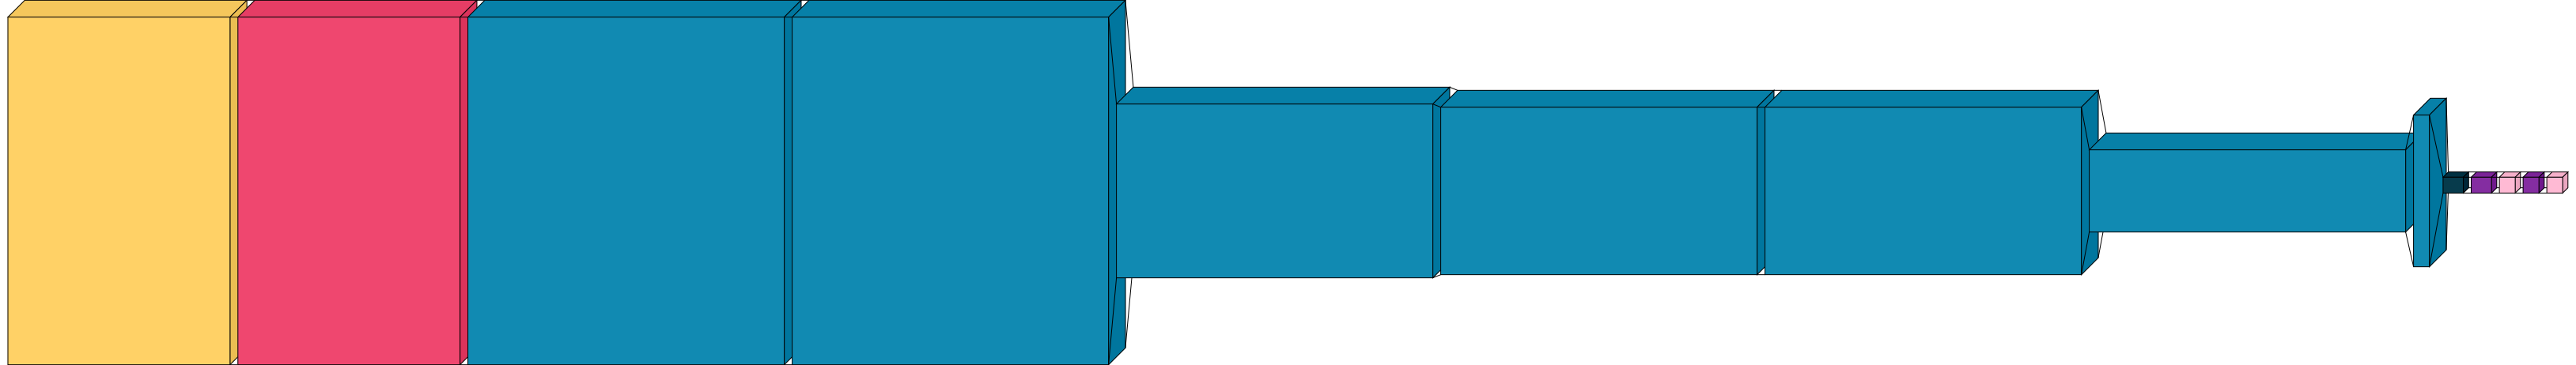

In [28]:
visualkeras.layered_view(model)

## Modeling

In [29]:
# Assume X and y are your full dataset and labels
# Example data shapes:
# X.shape = (806, 110, 104, 27, 16)
# y.shape = (806, )

# Split the data into training and holdout sets
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Callbacks for learning rate scheduling and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    epochs=20,  # Increased epochs for better convergence
    batch_size=4,  # Increased batch size for stable gradients
    validation_split=0.2,
    callbacks=[reduce_lr, early_stop]
)


Epoch 1/20


2024-11-10 16:36:22.916184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-10 16:36:22.923547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-10 16:36:22.927690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - ETA: 0s - loss: 0.8648 - accuracy: 0.5058 

2024-11-10 17:40:01.701582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-10 17:40:01.705075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-10 17:40:01.706926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 3881s 59s/step - loss: 0.8648 - accuracy: 0.5058 - val_loss: 0.8042 - val_accuracy: 0.5846 - lr: 0.0010
Epoch 2/20
65/65 [==============================] - 3890s 60s/step - loss: 0.8066 - accuracy: 0.4942 - val_loss: 0.7783 - val_accuracy: 0.5692 - lr: 0.0010
Epoch 3/20
65/65 [==============================] - 3736s 57s/step - loss: 0.7779 - accuracy: 0.5174 - val_loss: 0.7865 - val_accuracy: 0.4769 - lr: 0.0010
Epoch 4/20
65/65 [==============================] - 3476s 53s/step - loss: 0.7774 - accuracy: 0.5483 - val_loss: 0.7561 - val_accuracy: 0.5692 - lr: 0.0010
Epoch 5/20
65/65 [==============================] - 3560s 55s/step - loss: 0.7569 - accuracy: 0.5521 - val_loss: 0.7663 - val_accuracy: 0.4308 - lr: 0.0010
Epoch 6/20
65/65 [==============================] - 3741s 57s/step - loss: 0.7653 - accuracy: 0.5444 - val_loss: 0.7701 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 7/20
65/65 [==============================] - ETA: 0s - loss: 0.7442 

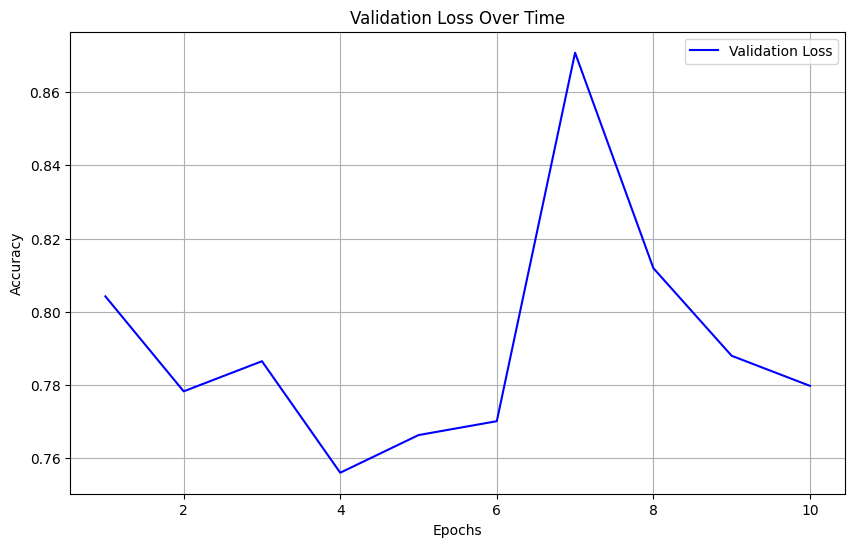

In [31]:
import matplotlib.pyplot as plt

# Extract the validation accuracy from history
val_accuracy = history.history['val_loss']

# Determine the number of epochs
epochs = range(1, len(val_accuracy) + 1)

# Plotting validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracy, 'b', label='Validation Loss')
plt.title('Validation Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# Evaluate the model on the holdout set
loss, accuracy = model.evaluate(X_holdout, y_holdout)
print(f"Holdout set loss: {loss:.4f}")
print(f"Holdout set accuracy: {accuracy:.4f}")

# Predict on the holdout set
y_pred = model.predict(X_holdout)

# Convert predictions to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print the first few predictions and corresponding true labels
print("Predictions on holdout set (first 5):", y_pred_binary[:5].flatten())
print("True labels on holdout set (first 5):", y_holdout[:5])

# Classification report for additional metrics
print(classification_report(y_holdout, y_pred_binary))
